ADF Test for Tesla Close Price:
  Test Statistic: -1.8361717943474192
  p-value: 0.3626569574409165
  Critical Values: {'1%': np.float64(-3.434886677803751), '5%': np.float64(-2.8635436366589673), '10%': np.float64(-2.5678367211155533)}
  Tesla Close Price is not stationary


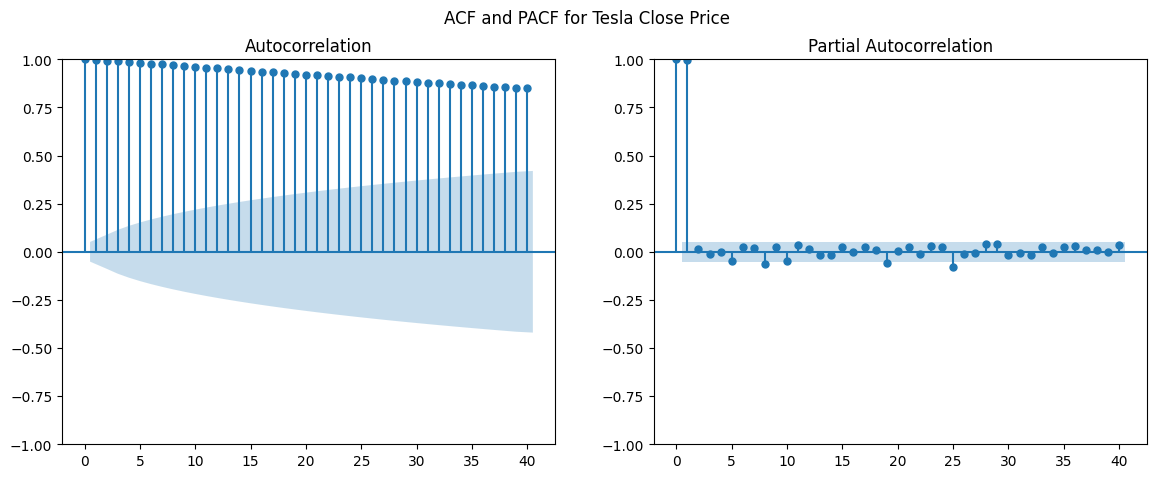

ADF Test for S&P 500 Close Price:
  Test Statistic: -0.6044405225769738
  p-value: 0.8699754904513046
  Critical Values: {'1%': np.float64(-3.434843038681996), '5%': np.float64(-2.8635243777871286), '10%': np.float64(-2.56782646544019)}
  S&P 500 Close Price is not stationary


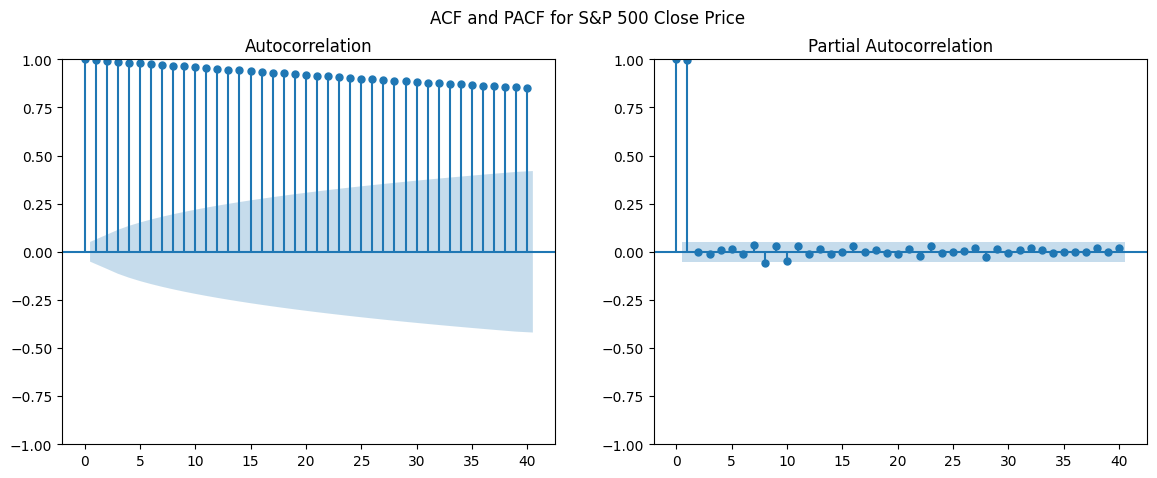

ADF Test for IXIC Close Price:
  Test Statistic: -0.8992045348348283
  p-value: 0.7882342628930419
  Critical Values: {'1%': np.float64(-3.434843038681996), '5%': np.float64(-2.8635243777871286), '10%': np.float64(-2.56782646544019)}
  IXIC Close Price is not stationary


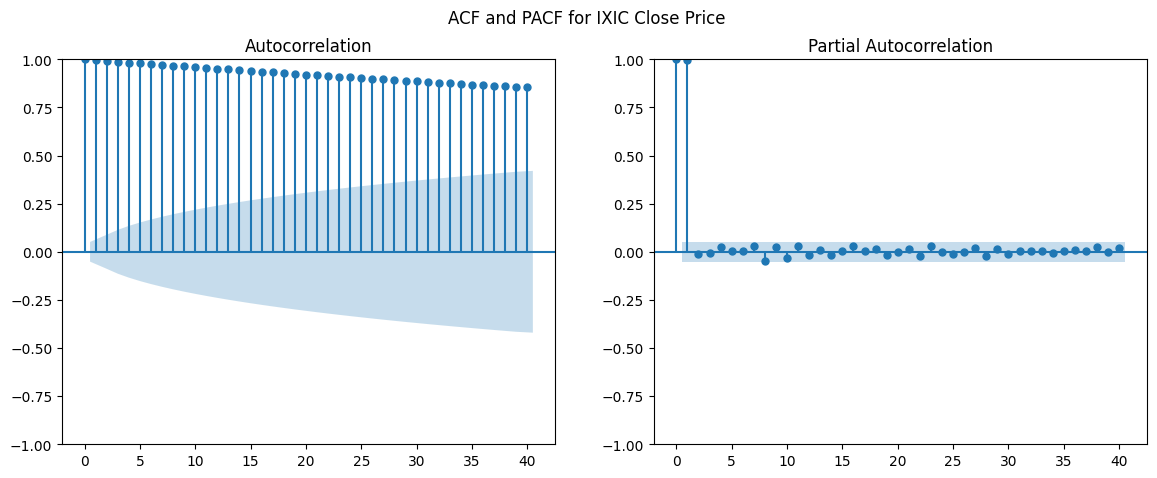

ADF Test for Close Differenced:
  Test Statistic: -7.59358054588458
  p-value: 2.4941707410649414e-11
  Critical Values: {'1%': np.float64(-3.434886677803751), '5%': np.float64(-2.8635436366589673), '10%': np.float64(-2.5678367211155533)}
  Close Differenced is stationary


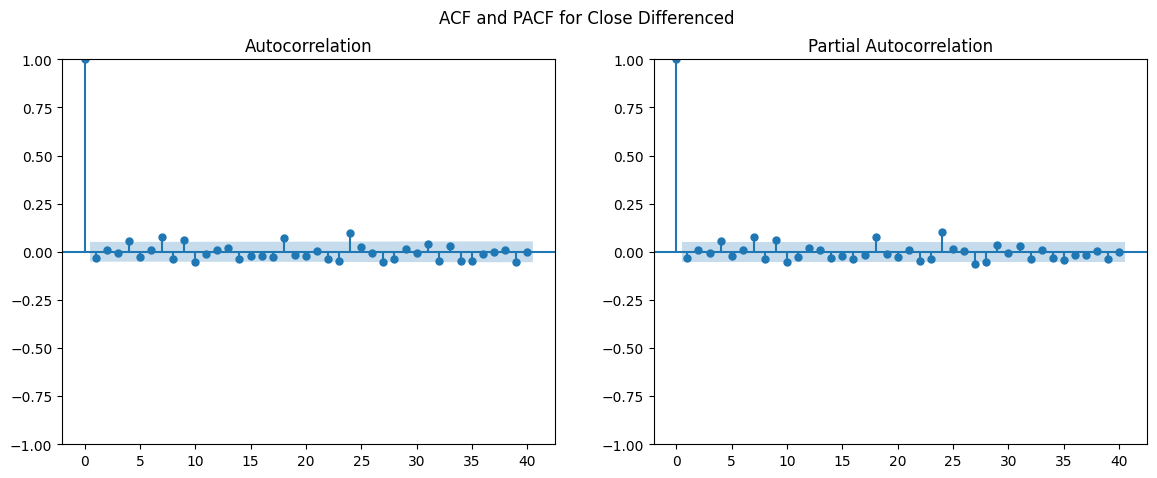

ADF Test for Close Differenced:
  Test Statistic: -11.807520204038207
  p-value: 9.022202135499528e-22
  Critical Values: {'1%': np.float64(-3.434843038681996), '5%': np.float64(-2.8635243777871286), '10%': np.float64(-2.56782646544019)}
  Close Differenced is stationary


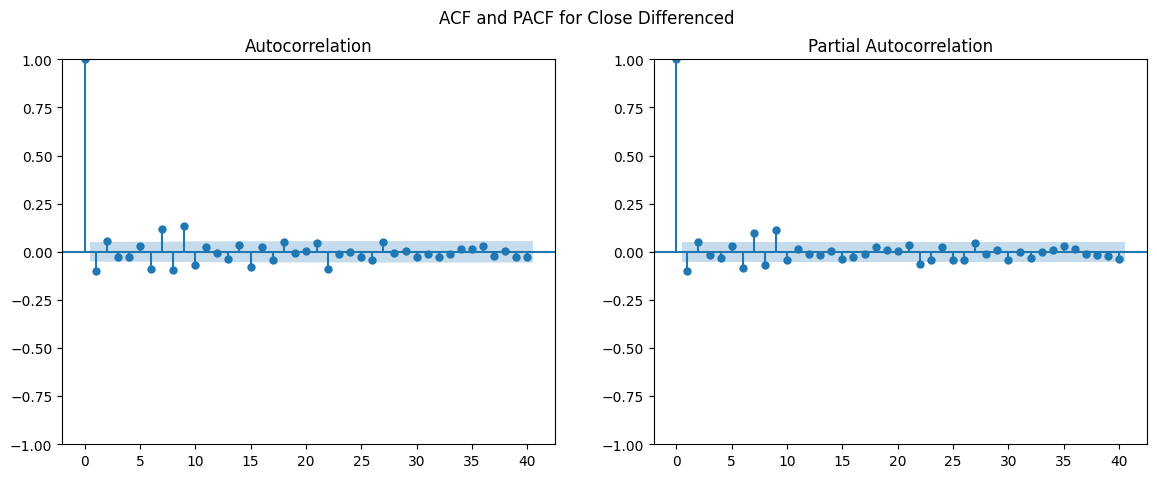

ADF Test for Close Differenced:
  Test Statistic: -12.076241534454265
  p-value: 2.2866969841651156e-22
  Critical Values: {'1%': np.float64(-3.434843038681996), '5%': np.float64(-2.8635243777871286), '10%': np.float64(-2.56782646544019)}
  Close Differenced is stationary


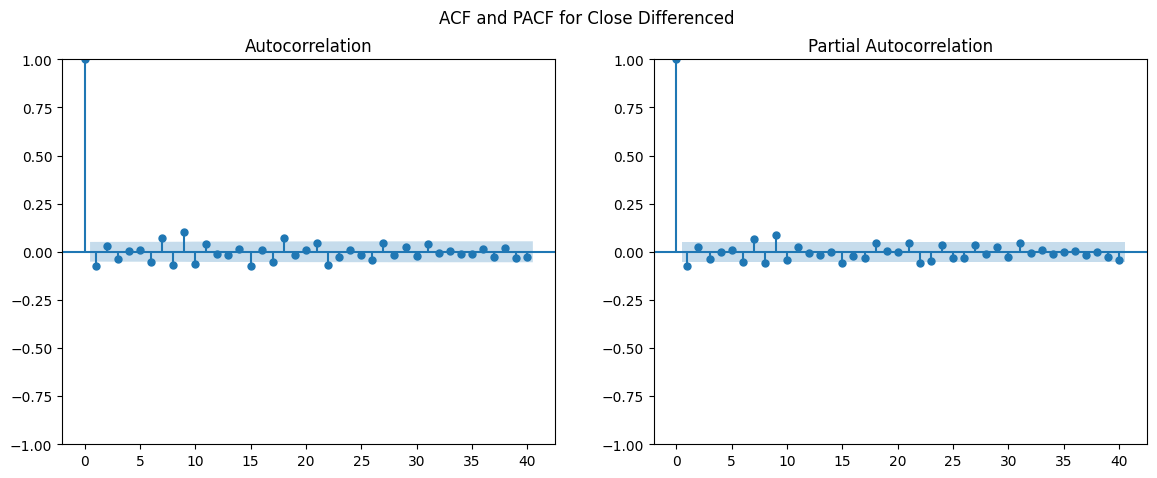

Stationarity check and differencing completed. Data saved.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Load data
tesla_data = pd.read_csv('../Get_data/Tesla_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('../Get_data/S&P500_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('../Get_data/IXIC_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')

# Task 1: Handle missing values and outliers
def clean_data(df):
    # Interpolate missing values
    df.interpolate(method='time', inplace=True)
    
    # Remove outliers based on Z-score
    z_scores = np.abs((df - df.mean()) / df.std())
    df[z_scores > 3] = np.nan  # Setting outliers as NaN
    df.interpolate(method='time', inplace=True)  # Re-interpolating outliers
    return df

tesla_data = clean_data(tesla_data)
sp500_data = clean_data(sp500_data)
ixic_data = clean_data(ixic_data)

# Task 2: Check stationarity with ADF test and plot ACF/PACF
def check_stationarity_acf_pacf(series, name, lags=40):
    # ADF Test
    result = adfuller(series.dropna())
    print(f'ADF Test for {name}:')
    print(f'  Test Statistic: {result[0]}')
    print(f'  p-value: {result[1]}')
    print(f'  Critical Values: {result[4]}')
    if result[1] < 0.05:
        print(f'  {name} is stationary')
    else:
        print(f'  {name} is not stationary')
    
    # Plot ACF and PACF
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(series.dropna(), lags=lags, ax=ax[0])
    plot_pacf(series.dropna(), lags=lags, ax=ax[1])
    plt.suptitle(f'ACF and PACF for {name}')
    plt.show()

# Apply ACF/PACF checks
check_stationarity_acf_pacf(tesla_data['Close'], 'Tesla Close Price')
check_stationarity_acf_pacf(sp500_data['Close'], 'S&P 500 Close Price')
check_stationarity_acf_pacf(ixic_data['Close'], 'IXIC Close Price')

# Task 3: Apply differencing if data is not stationary
def difference_series(df, column_name):
    adf_test_result = adfuller(df[column_name].dropna())
    if adf_test_result[1] >= 0.05:
        df[f'{column_name}_diff'] = df[column_name].diff().dropna()
        check_stationarity_acf_pacf(df[f'{column_name}_diff'], f'{column_name} Differenced')
    else:
        print(f'{column_name} is already stationary, no differencing needed.')
    return df

# Difference the series if needed
tesla_data = difference_series(tesla_data, 'Close')
sp500_data = difference_series(sp500_data, 'Close')
ixic_data = difference_series(ixic_data, 'Close')

# Add Close_predicted column based on Close and Close_diff
def add_predicted_close(df, column_name='Close'):
    if f'{column_name}_diff' in df.columns:
        # Calculate Close_predicted using the previous Close value and the current Close_diff value
        df[f'{column_name}_predicted'] = df[column_name] + df[f'{column_name}_diff']
    else:
        print(f'{column_name}_diff not found. Please compute the differenced column first.')
    return df

# Apply the function to add Close_predicted column
tesla_data = add_predicted_close(tesla_data)
sp500_data = add_predicted_close(sp500_data)
ixic_data = add_predicted_close(ixic_data)

# Save cleaned and transformed data
tesla_data.to_csv('Cleaned_Tesla_Close.csv')
sp500_data.to_csv('Cleaned_SP500_Close.csv')
ixic_data.to_csv('Cleaned_IXIC_Close.csv')

print("Stationarity check and differencing completed. Data saved.")
